# ======================================
# MLDL COURSE PROJECT — FLOOD SEGMENTATION
# =====================================
"""
Week 1 — Project Proposal (in code comments)

Sub-Topic and Title:
    "Semantic Segmentation for Flood Extent Mapping in Aerial Imagery"

Problem Statement:
    Accurate and timely flood extent mapping is critical in disaster management for
    assessing damage, planning evacuation routes, and allocating resources.
    Traditional manual mapping is slow, subjective, and does not scale with the
    large volume of aerial/satellite imagery collected during disasters.
    This project uses deep learning–based semantic segmentation to automatically
    identify different land-cover classes in flood imagery (e.g., flooded areas,
    water, vegetation, etc.) to support rapid flood damage assessment.

Dataset:
    A publicly available flood-segmentation dataset with:
      - RGB images under "images/<scene_id>/*.jpg"
      - Corresponding RGB-encoded semantic masks under
        "annotations/<scene_id>/*.png"
    Each mask pixel belongs to one of 6 classes, encoded via specific RGB colors.
    (You can cite the dataset’s official paper/URL in your report.)

Model Approach:
    - Main model: U-Net-style convolutional neural network (CNN) for semantic
      segmentation with 6 output classes.
    - Baseline: Simple majority-class mask (predict the most frequent class for
      all pixels) for comparison with U-Net’s IoU and pixel accuracy.

Evaluation Metrics:
    - Pixel Accuracy (overall)
    - Mean Intersection-over-Union (mIoU) across 6 classes
    - Per-class Precision and Recall
"""


In [10]:

# ============================================================
# STEP 0 — SETUP & EXTRACT DATA
# ============================================================
!apt-get install -y unrar

import os
import numpy as np
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import torch.nn as nn
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (8, 6)

# Paths
RAR_PATH = "/content/FloodNet.rar"          # make sure this exists in Colab
EXTRACT_TO = "/content/FloodNet"           # extraction folder

# Extract only once
if not os.path.exists(os.path.join(EXTRACT_TO, "FloodNet")):
    os.makedirs(EXTRACT_TO, exist_ok=True)
    print("Extracting FloodNet.rar ...")
    !unrar x "{RAR_PATH}" "{EXTRACT_TO}/"
else:
    print("Dataset already extracted.")

ROOT_DIR = "/content/FloodNet/FloodNet"
IMG_DIR = os.path.join(ROOT_DIR, "images")
MASK_DIR = os.path.join(ROOT_DIR, "annotations")

print("ROOT_DIR:", ROOT_DIR)
print("Images dir exists:", os.path.exists(IMG_DIR))
print("Masks dir exists:", os.path.exists(MASK_DIR))


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
unrar is already the newest version (1:6.1.5-1ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 41 not upgraded.
Dataset already extracted.
ROOT_DIR: /content/FloodNet/FloodNet
Images dir exists: True
Masks dir exists: True


In [11]:
# ============================================================
# STEP 1 — COLOR PALETTE (FROM MASKS)  [Week 1: Dataset]
# ============================================================
# These 6 RGB colors come from your "Unique RGB colors" analysis:
color_palette = [
    (61, 61, 245),
    (250, 50, 83),
    (255, 96, 55),
    (51, 221, 255),
    (102, 255, 102),
    (92, 179, 162),
]

color_to_class = {c: i for i, c in enumerate(color_palette)}
num_classes = len(color_palette)

print("\nColor → Class mapping:")
for c, i in color_to_class.items():
    print(f"  {c} -> class {i}")
print("Total classes:", num_classes)


Color → Class mapping:
  (61, 61, 245) -> class 0
  (250, 50, 83) -> class 1
  (255, 96, 55) -> class 2
  (51, 221, 255) -> class 3
  (102, 255, 102) -> class 4
  (92, 179, 162) -> class 5
Total classes: 6


In [12]:
# ============================================================
# STEP 2 — DATASET CLASS  [Used in all weeks]
# ============================================================
class FloodSegDataset(Dataset):
    """
    Semantic segmentation dataset for flood imagery.

    - root/images/<scene_id>/*.jpg
    - root/annotations/<scene_id>/*.png

    Each mask is RGB-colored; we map colors -> class IDs [0..5].
    """

    def __init__(self, root, transform=None, img_size=(256, 256)):
        self.img_root = os.path.join(root, "images")
        self.mask_root = os.path.join(root, "annotations")
        self.transform = transform
        self.img_size = img_size
        self.samples = []

        # Walk through scene folders
        for scene in os.listdir(self.img_root):
            img_scene = os.path.join(self.img_root, scene)
            mask_scene = os.path.join(self.mask_root, scene)

            if not os.path.isdir(img_scene):
                continue

            for fname in os.listdir(img_scene):
                if fname.lower().endswith(".jpg"):
                    base = fname[:-4]
                    img_path = os.path.join(img_scene, fname)
                    mask_path = os.path.join(mask_scene, base + ".png")

                    if os.path.exists(mask_path):
                        self.samples.append((img_path, mask_path))

        print("Total image-mask pairs:", len(self.samples))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, mask_path = self.samples[idx]

        img = Image.open(img_path).convert("RGB")
        mask_img = Image.open(mask_path).convert("RGB")

        # Resize both
        img = img.resize(self.img_size)
        mask_img = mask_img.resize(self.img_size, Image.NEAREST)

        # Convert RGB mask -> class mask
        mask_arr = np.array(mask_img)
        h, w, _ = mask_arr.shape
        mask_class = np.zeros((h, w), dtype=np.int64)

        for color, cid in color_to_class.items():
            mask_class[(mask_arr == color).all(axis=2)] = cid

        if self.transform:
            img = self.transform(img)
        else:
            img = transforms.ToTensor()(img)

        mask_tensor = torch.tensor(mask_class, dtype=torch.long)

        return img, mask_tensor

In [13]:
# ============================================================
# STEP 3 — CREATE DATASET & DATALOADERS
#            [Week 2-3: Preprocessing + EDA]
# ============================================================
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],
                         [0.229,0.224,0.225])
])

full_dataset = FloodSegDataset(ROOT_DIR, transform=transform, img_size=(256,256))

# Train/val split (80/20)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_dataset,   batch_size=4, shuffle=False, num_workers=2)

print(f"Train samples: {len(train_dataset)}, Val samples: {len(val_dataset)}")

Total image-mask pairs: 3574
Train samples: 2859, Val samples: 715



Approximate class pixel distribution:
Class 0: 3080121 pixels (23.50%)
Class 1: 4161734 pixels (31.75%)
Class 2: 1099070 pixels (8.39%)
Class 3: 4530524 pixels (34.57%)
Class 4: 0 pixels (0.00%)
Class 5: 235751 pixels (1.80%)


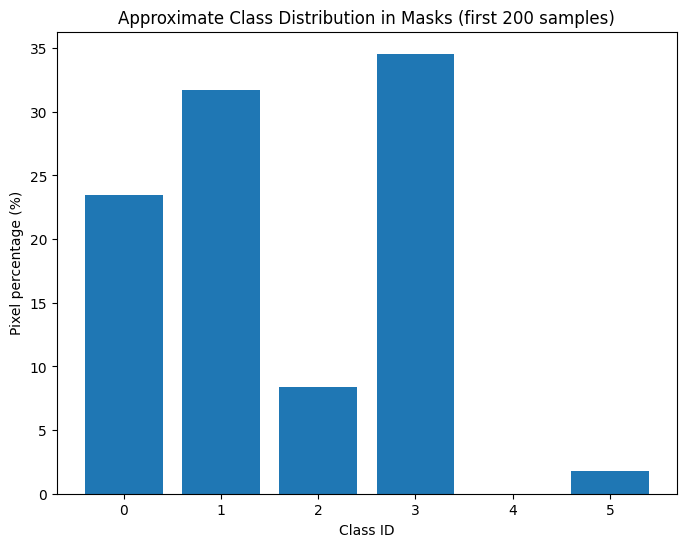

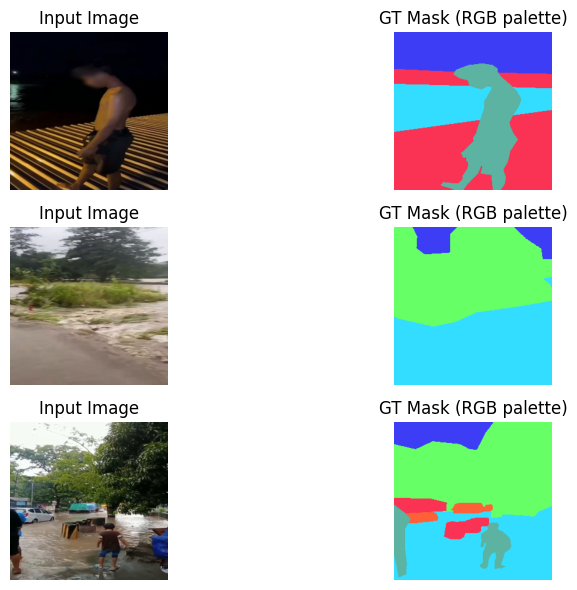

In [14]:
# ============================================================
# STEP 4 — EDA & CLASS DISTRIBUTION  [Week 2-3: EDA]
# ============================================================
def compute_class_distribution(dataset, max_samples=200):
    """
    Compute approximate distribution of classes in masks
    using up to max_samples from dataset.
    """
    counts = np.zeros(num_classes, dtype=np.int64)
    n = min(max_samples, len(dataset))

    for i in range(n):
        _, mask = dataset[i]   # mask is (H,W)
        mask_np = mask.numpy().flatten()
        for c in range(num_classes):
            counts[c] += np.sum(mask_np == c)

    return counts

class_counts = compute_class_distribution(full_dataset, max_samples=200)
class_props = class_counts / class_counts.sum()

print("\nApproximate class pixel distribution:")
for c, cnt in enumerate(class_counts):
    print(f"Class {c}: {cnt} pixels ({class_props[c]*100:.2f}%)")

# Bar plot
plt.figure()
plt.bar(range(num_classes), class_props * 100)
plt.xlabel("Class ID")
plt.ylabel("Pixel percentage (%)")
plt.title("Approximate Class Distribution in Masks (first 200 samples)")
plt.show()

# Show a few example image+mask pairs (EDA)
def decode_mask(mask_class):
    """Convert class mask (H,W) -> RGB mask (H,W,3)."""
    h, w = mask_class.shape
    rgb = np.zeros((h, w, 3), dtype=np.uint8)
    for color, cid in color_to_class.items():
        rgb[mask_class == cid] = color
    return rgb

imgs, masks = next(iter(train_loader))
imgs_np = imgs.numpy().transpose(0,2,3,1)  # (B,H,W,C)
masks_np = masks.numpy()

plt.figure(figsize=(10, 6))
for i in range(min(3, imgs_np.shape[0])):
    plt.subplot(3, 2, 2*i+1)
    img_show = (imgs_np[i] * [0.229,0.224,0.225] + [0.485,0.456,0.406])
    img_show = np.clip(img_show, 0, 1)
    plt.imshow(img_show)
    plt.title("Input Image")
    plt.axis("off")

    plt.subplot(3, 2, 2*i+2)
    plt.imshow(decode_mask(masks_np[i]))
    plt.title("GT Mask (RGB palette)")
    plt.axis("off")

plt.tight_layout()
plt.show()

In [15]:
# ============================================================
# STEP 5 — U-NET MODEL  [Week 2-3: Initial Model]
# ============================================================
class UNet(nn.Module):
    def __init__(self, n_classes):
        super().__init__()

        def CBR(in_ch, out_ch):
            return nn.Sequential(
                nn.Conv2d(in_ch, out_ch, 3, padding=1),
                nn.BatchNorm2d(out_ch),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_ch, out_ch, 3, padding=1),
                nn.BatchNorm2d(out_ch),
                nn.ReLU(inplace=True),
            )

        self.down1 = CBR(3, 64)
        self.down2 = CBR(64, 128)
        self.down3 = CBR(128, 256)
        self.down4 = CBR(256, 512)
        self.pool = nn.MaxPool2d(2)

        self.mid = CBR(512, 1024)

        self.up4 = nn.ConvTranspose2d(1024, 512, 2, stride=2)
        self.dec4 = CBR(1024, 512)

        self.up3 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.dec3 = CBR(512, 256)

        self.up2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.dec2 = CBR(256, 128)

        self.up1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec1 = CBR(128, 64)

        self.final = nn.Conv2d(64, n_classes, 1)

    def forward(self, x):
        e1 = self.down1(x)
        e2 = self.down2(self.pool(e1))
        e3 = self.down3(self.pool(e2))
        e4 = self.down4(self.pool(e3))

        mid = self.mid(self.pool(e4))

        d4 = self.up4(mid)
        d4 = self.dec4(torch.cat([d4, e4], dim=1))

        d3 = self.up3(d4)
        d3 = self.dec3(torch.cat([d3, e3], dim=1))

        d2 = self.up2(d3)
        d2 = self.dec2(torch.cat([d2, e2], dim=1))

        d1 = self.up1(d2)
        d1 = self.dec1(torch.cat([d1, e1], dim=1))

        return self.final(d1)

In [16]:
# ============================================================
# STEP 6 — TRAINING SETUP + METRICS  [Week 2-3 & Week 4-5]
# ============================================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("\nUsing device:", device)

model = UNet(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

def pixel_accuracy(pred, target):
    """
    pred, target: (B,H,W)
    """
    correct = (pred == target).sum().item()
    total = target.numel()
    return correct / total

def iou_score(pred, target, num_classes):
    """
    Mean IoU over num_classes.
    pred, target: (B,H,W)
    """
    ious = []
    for c in range(num_classes):
        pred_c = (pred == c)
        tgt_c  = (target == c)
        intersection = (pred_c & tgt_c).sum().item()
        union = (pred_c | tgt_c).sum().item()
        if union == 0:
            continue
        ious.append(intersection / union)
    if len(ious) == 0:
        return 0.0
    return np.mean(ious)


Using device: cuda



Epoch 1/10
Train Loss: 0.9421
Val Loss:   0.7005
Val Acc:    76.82%
Val mIoU:   0.4029

Epoch 2/10
Train Loss: 0.6863
Val Loss:   0.6057
Val Acc:    79.68%
Val mIoU:   0.4819

Epoch 3/10
Train Loss: 0.5686
Val Loss:   0.5069
Val Acc:    83.02%
Val mIoU:   0.5076

Epoch 4/10
Train Loss: 0.4629
Val Loss:   0.3844
Val Acc:    87.53%
Val mIoU:   0.6015

Epoch 5/10
Train Loss: 0.3951
Val Loss:   0.3632
Val Acc:    87.72%
Val mIoU:   0.6036

Epoch 6/10
Train Loss: 0.3382
Val Loss:   0.3142
Val Acc:    89.55%
Val mIoU:   0.6232

Epoch 7/10
Train Loss: 0.2836
Val Loss:   0.2876
Val Acc:    90.29%
Val mIoU:   0.6537

Epoch 8/10
Train Loss: 0.2541
Val Loss:   0.2779
Val Acc:    90.68%
Val mIoU:   0.6745

Epoch 9/10
Train Loss: 0.2298
Val Loss:   0.2379
Val Acc:    91.75%
Val mIoU:   0.7111

Epoch 10/10
Train Loss: 0.2009
Val Loss:   0.2122
Val Acc:    92.78%
Val mIoU:   0.7354


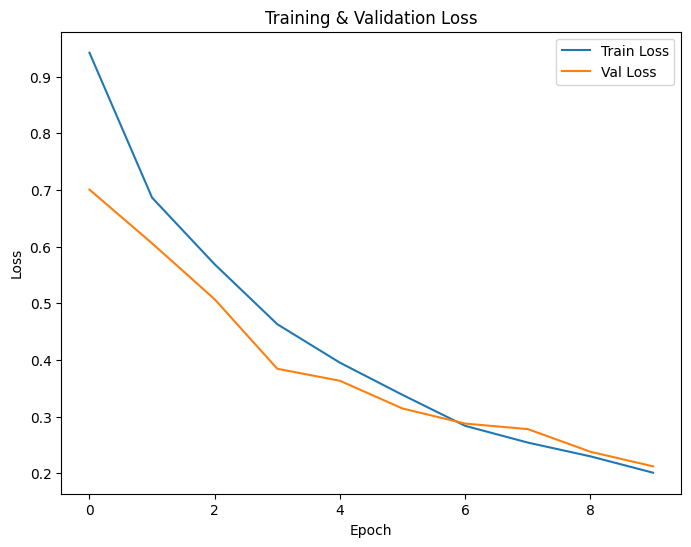

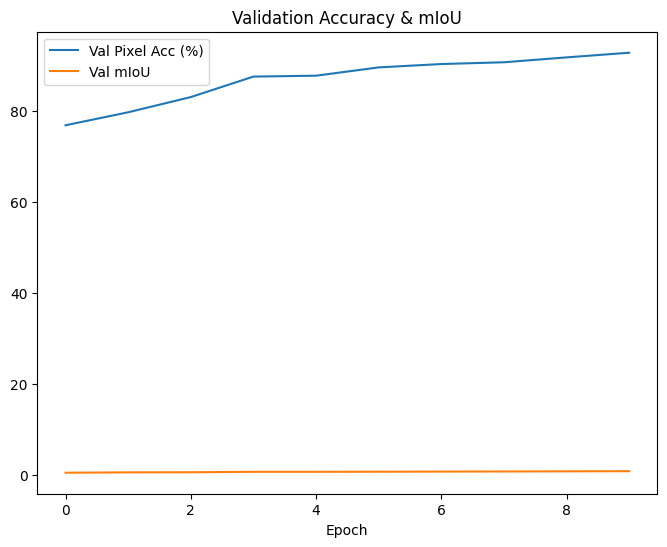

In [17]:
# ============================================================
# STEP 7 — TRAIN LOOP WITH LOSS, ACC, mIoU  [Week 2-3, 4-5]
# ============================================================
EPOCHS = 10
train_losses, val_losses = [], []
val_accs, val_mious = [], []

for epoch in range(EPOCHS):
    # ---- Train ----
    model.train()
    total_train_loss = 0

    for imgs, masks in train_loader:
        imgs, masks = imgs.to(device), masks.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)     # (B,C,H,W)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_loader)

    # ---- Validate ----
    model.eval()
    total_val_loss = 0
    total_acc = 0
    total_iou = 0
    batches = 0

    with torch.no_grad():
        for imgs, masks in val_loader:
            imgs, masks = imgs.to(device), masks.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, masks)
            total_val_loss += loss.item()

            preds = torch.argmax(outputs, dim=1)
            total_acc += pixel_accuracy(preds, masks)
            total_iou += iou_score(preds, masks, num_classes)
            batches += 1

    avg_val_loss = total_val_loss / len(val_loader)
    avg_acc = total_acc / batches
    avg_miou = total_iou / batches

    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    val_accs.append(avg_acc)
    val_mious.append(avg_miou)

    print(f"\nEpoch {epoch+1}/{EPOCHS}")
    print(f"Train Loss: {avg_train_loss:.4f}")
    print(f"Val Loss:   {avg_val_loss:.4f}")
    print(f"Val Acc:    {avg_acc*100:.2f}%")
    print(f"Val mIoU:   {avg_miou:.4f}")

# Plot loss curves (for Intermediate Update 1/2)
plt.figure()
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.legend()
plt.show()

plt.figure()
plt.plot([a*100 for a in val_accs], label="Val Pixel Acc (%)")
plt.plot(val_mious, label="Val mIoU")
plt.xlabel("Epoch")
plt.title("Validation Accuracy & mIoU")
plt.legend()
plt.show()

In [18]:
# ============================================================
# STEP 8 — FINAL EVALUATION (Per-class Precision/Recall)
#          [Week 4-5: Experimentation + Evaluation]
# ============================================================
def per_class_precision_recall(model, loader, num_classes):
    model.eval()
    TP = np.zeros(num_classes, dtype=np.int64)
    FP = np.zeros(num_classes, dtype=np.int64)
    FN = np.zeros(num_classes, dtype=np.int64)

    with torch.no_grad():
        for imgs, masks in loader:
            imgs, masks = imgs.to(device), masks.to(device)
            outputs = model(imgs)
            preds = torch.argmax(outputs, dim=1)

            for c in range(num_classes):
                pred_c = (preds == c)
                tgt_c  = (masks == c)

                TP[c] += (pred_c & tgt_c).sum().item()
                FP[c] += (pred_c & ~tgt_c).sum().item()
                FN[c] += (~pred_c & tgt_c).sum().item()

    precision = np.zeros(num_classes)
    recall = np.zeros(num_classes)

    for c in range(num_classes):
        if TP[c] + FP[c] > 0:
            precision[c] = TP[c] / (TP[c] + FP[c])
        else:
            precision[c] = np.nan
        if TP[c] + FN[c] > 0:
            recall[c] = TP[c] / (TP[c] + FN[c])
        else:
            recall[c] = np.nan

    return precision, recall

prec, rec = per_class_precision_recall(model, val_loader, num_classes)

print("\nPer-class Precision & Recall (Validation):")
for c in range(num_classes):
    print(f"Class {c}: Precision={prec[c]:.3f}, Recall={rec[c]:.3f}")

print(f"\nMacro Precision: {np.nanmean(prec):.3f}")
print(f"Macro Recall:    {np.nanmean(rec):.3f}")
print(f"Best Val Pixel Acc: {max(val_accs)*100:.2f}%")
print(f"Best Val mIoU:      {max(val_mious):.4f}")


Per-class Precision & Recall (Validation):
Class 0: Precision=0.900, Recall=0.959
Class 1: Precision=0.928, Recall=0.900
Class 2: Precision=0.878, Recall=0.865
Class 3: Precision=0.959, Recall=0.953
Class 4: Precision=0.868, Recall=0.866
Class 5: Precision=0.847, Recall=0.834

Macro Precision: 0.897
Macro Recall:    0.896
Best Val Pixel Acc: 92.78%
Best Val mIoU:      0.7354


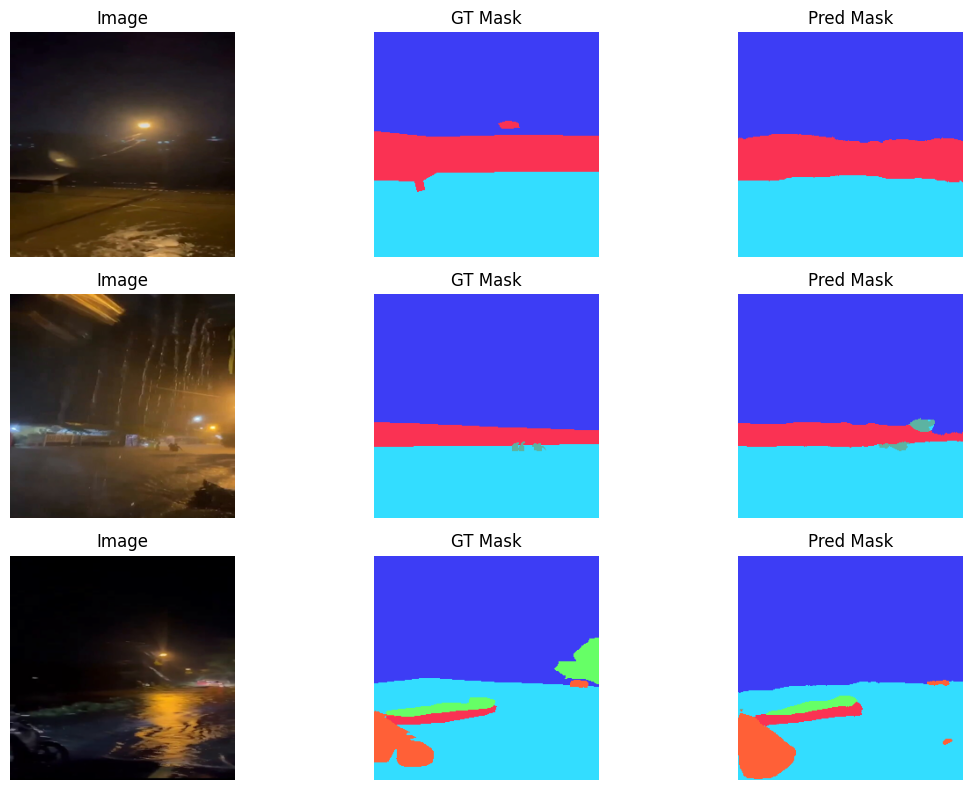

In [19]:
# ============================================================
# STEP 9 — VISUALIZE PREDICTIONS (Qualitative Results)
# ============================================================
model.eval()
imgs, masks = next(iter(val_loader))
imgs = imgs.to(device)

with torch.no_grad():
    logits = model(imgs)
    preds = torch.argmax(logits, dim=1).cpu()

imgs_np = imgs.cpu().permute(0,2,3,1).numpy()
masks_np = masks.numpy()
preds_np = preds.numpy()

plt.figure(figsize=(12, 8))
for i in range(min(3, imgs_np.shape[0])):
    # Input image
    plt.subplot(3,3,3*i+1)
    img_show = (imgs_np[i] * [0.229,0.224,0.225] + [0.485,0.456,0.406])
    img_show = np.clip(img_show, 0, 1)
    plt.imshow(img_show)
    plt.title("Image")
    plt.axis("off")

    # Ground truth
    plt.subplot(3,3,3*i+2)
    plt.imshow(decode_mask(masks_np[i]))
    plt.title("GT Mask")
    plt.axis("off")

    # Prediction
    plt.subplot(3,3,3*i+3)
    plt.imshow(decode_mask(preds_np[i]))
    plt.title("Pred Mask")
    plt.axis("off")

plt.tight_layout()
plt.show()